## 04. Github with different Tuplex modes
This notebook contains analysis of the results when running `github/run-tuplex-experiments.sh`. As sampling mode first/last file and first/last rows are used (this is different than the default tuplex sampling mode!).

In [302]:
import pandas as pd
import json
import zipfile

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pathlib
sns.set_style('darkgrid')
from matplotlib.ticker import EngFormatter

In [106]:
# load results from path for plotting
results_path = '../github/local-exp/github/combined.ndjson'
df = pd.read_json(results_path, lines=True)

In [107]:
df.head()

,run,mode,input_path,output_path,time_in_s,loading_time_in_s,total_time_in_s,input_row_count,output_row_count,benchmark,metrics,startup_time_in_s,per_file_stats,hyper,request_time_in_s,compile_time_in_s,fast_path_execution_time_in_s,general_and_interpreter_time_in_s,hyperspecialization_time
0,3,python,/hot/data/github_daily/2011-10-15.json,./local-exp/github//output/python,0.332677,NaN,135.317727,48899,1418,github,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
1,3,python,/hot/data/github_daily/2012-10-15.json,./local-exp/github//output/python,1.165685,NaN,135.317727,165692,5907,github,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
2,3,python,/hot/data/github_daily/2013-10-15.json,./local-exp/github//output/python,2.382360,NaN,135.317727,296456,10628,github,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
3,3,python,/hot/data/github_daily/2014-10-15.json,./local-exp/github//output/python,8.686575,NaN,135.317727,476393,16014,github,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
4,3,python,/hot/data/github_daily/2015-10-15.json,./local-exp/github//output/python,7.443211,NaN,135.317727,737714,25301,github,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
# Plot modes against each other (horizontal) incl. how much time is spent on hyperspecialization, client-side, request side.

In [297]:
def compute_df_totals(df):
    # ignore first warm-up/verification run
    df = df[df['run'] != 0].copy()
    
    part_df_A = df.groupby(['run', 'mode'])[['hyperspecialization_time', 'request_time_in_s']].sum()
    # combine with total runtime
    part_df_B = df.groupby(['run', 'mode'])[['total_time_in_s']].first()
    
    df_totals = pd.concat((part_df_A, part_df_B), axis=1).reset_index()
    
    df_totals = df_totals.sort_values(by='total_time_in_s').reset_index(drop=True)

    return df_totals

In [243]:

modes

array(['tuplex-hyper-sparse-structs', 'tuplex-global-sparse-structs',
       'tuplex-hyper-generic-dicts', 'tuplex-global-generic-dicts',
       'tuplex-global-structs', 'python'], dtype=object)

In [305]:
def plot_scatter(df, path):
    df_totals = compute_df_totals(df)

    modes = df_totals['mode'].unique()
    
    for i, mode in enumerate(modes):
        y = df_totals[df_totals['mode'] == mode]['total_time_in_s']
        x = [i] * len(y)
        plt.scatter(y, x, linewidth=2, marker='x')
    ax = plt.gca()
    ax.set_yticklabels(modes)
    plt.yticks(range(len(modes)), rotation=0)
    ax.xaxis.set_major_formatter(EngFormatter(unit='s', sep=''))
    plt.grid(axis='y')
    plt.title('hyper vs. global\n(same optimizations applied)')

    os.makedirs(pathlib.Path(path).parent, exist_ok=True)
    plt.savefig(path, dpi=120, bbox_inches='tight', pad_inches=0.5, transparent=True)

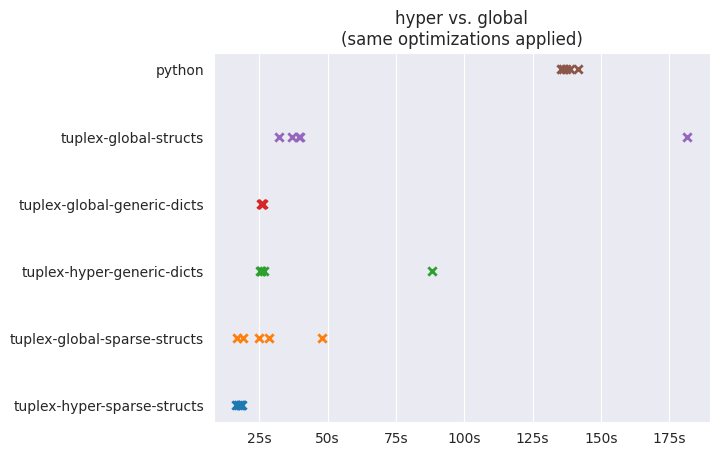

In [306]:
plot_scatter(df, 'plots/tuplex-hyper-vs-global-scatter.png')

In [307]:
# Breakdown plot, i.e. using averages + std for now


gdf

mode  run                      \
                                mean       std  q10  q90   
0   tuplex-hyper-sparse-structs  3.0  1.581139  3.0  4.6   
1   tuplex-global-generic-dicts  3.0  1.581139  3.0  4.6   
2  tuplex-global-sparse-structs  3.0  1.581139  3.0  4.6   
3    tuplex-hyper-generic-dicts  3.0  1.581139  3.0  4.6   
4         tuplex-global-structs  3.0  1.581139  3.0  4.6   
5                        python  3.0  1.581139  3.0  4.6   

  hyperspecialization_time                               request_time_in_s  \
                      mean       std       q10       q90              mean   
0                  4.48186  0.810218  4.049194  5.378826         17.100139   
1                  0.00000  0.000000  0.000000  0.000000         25.465658   
2                  0.00000  0.000000  0.000000  0.000000         19.699342   
3                  0.00000  0.000000  0.000000  0.000000         37.714897   
4                  0.00000  0.000000  0.000000  0.000000         57.888695   
5                  0.00000  0.000000  0.000000  0.000000          0.000000   

                                    total_time_in_s                         \
         std        q10         q90            mean        std         q10   
0   0.763562  17.345355   17.805210       17.672531   0.841686   17.858965   
1   0.285328  25.587888   25.700048       26.008024   0.288771   26.137623   
2   9.992661  15.626427   28.879662       27.401593  12.418418   24.839363   
3  27.866314  25.115469   63.025579       38.243744  27.871835   25.635654   
4  68.680441  26.599642  120.286051       66.052436  64.665360   39.615109   
5   0.000000   0.000000    0.000000      137.769170   2.479254  137.029233   

              other_time_in_s compute_time_in_s  
          q90            mean              mean  
0   18.478392        0.572392         12.618279  
1   26.243210        0.542366         25.465658  
2   40.187735        7.702251         19.699342  
3   63.563465        0.528847         37.714897  
4  124.975192        8.163741         57.888695  
5  140.452733      137.769170          0.000000

In [308]:

def plot_breakdown(df, path):

    df_totals = compute_df_totals(df)
    
    # 10th Percentile
    def q10(x):
        return x.quantile(0.5)
    
    # 90th Percentile
    def q90(x):
        return x.quantile(0.9)
    
    gdf = df_totals.groupby('mode').agg(['mean', 'std', q10, q90]).reset_index()
    
    gdf[('other_time_in_s', 'mean')] = gdf[('total_time_in_s', 'mean')] - gdf[('request_time_in_s', 'mean')]
    gdf[('compute_time_in_s', 'mean')] = gdf[('request_time_in_s', 'mean')] - gdf[('hyperspecialization_time', 'mean')]
    gdf = gdf.sort_values(by=('total_time_in_s', 'mean')).reset_index(drop=True)
    
    plt.figure(figsize=(10,5))
    kwargs={'edgecolor':None, 'lw':0}
    
    h = gdf[('compute_time_in_s', 'mean')]
    plt.barh(gdf.index, h, **kwargs, label='time spent on compute on individual requests')
    hh = gdf[('hyperspecialization_time', 'mean')]
    plt.barh(gdf.index, hh, left=h, **kwargs, label='time spent on hyperspecialization')
    hhh = gdf[('other_time_in_s', 'mean')]
    handle = plt.barh(gdf.index, hhh, left=h + hh, **kwargs, label='time spent on client (global optimization/compilation)')
    # modify python handle
    handle[-1].set_color([.5]*3)
    # plot total error bar
    mu = gdf[('total_time_in_s', 'mean')]
    sigma = gdf[('total_time_in_s', 'std')]
    q10 = gdf[('total_time_in_s', 'q10')]
    q90 = gdf[('total_time_in_s', 'q90')]
    
    for lower,upper,y in zip(q10,q90,range(len(q10))):
        plt.plot((lower,upper),(y,y),'ro-',color=[0.2]*3, markersize=3)
    
    plt.scatter(mu, gdf.index, 40, marker='o', color='k',zorder=10)
    
    # print runtime numbers in s
    for xi, yi in zip(mu, range(len(mu))):
        plt.text(xi + 1.5, yi + .2, f'{xi:.1f}s', horizontalalignment='left', verticalalignment='center')
    
    modes = list(gdf['mode'])
    ax = plt.gca()
    ax.set_yticklabels(modes)
    plt.yticks(range(len(modes)), rotation=0)
    ax.xaxis.set_major_formatter(EngFormatter(unit='s', sep=''))
    
    plt.text(85, 1, 'Optimizations used\nfor all settings:\n- filter-promotion\n- constant-folding\n- selection-pushdown\n- simplify-large-structs\n  (except for global-structs)', fontsize = 10, 
             bbox = dict(facecolor = 'white', alpha = 0.5))
    
    plt.grid(axis='y')
    plt.title('Breakdown: hyper vs. global\n(same optimizations applied)')
    plt.xlim(0, 160)
    plt.legend(loc='best')
    plt.tight_layout()

    os.makedirs(pathlib.Path(path).parent, exist_ok=True)
    plt.savefig(path, dpi=120, bbox_inches='tight', pad_inches=0.5, transparent=True)

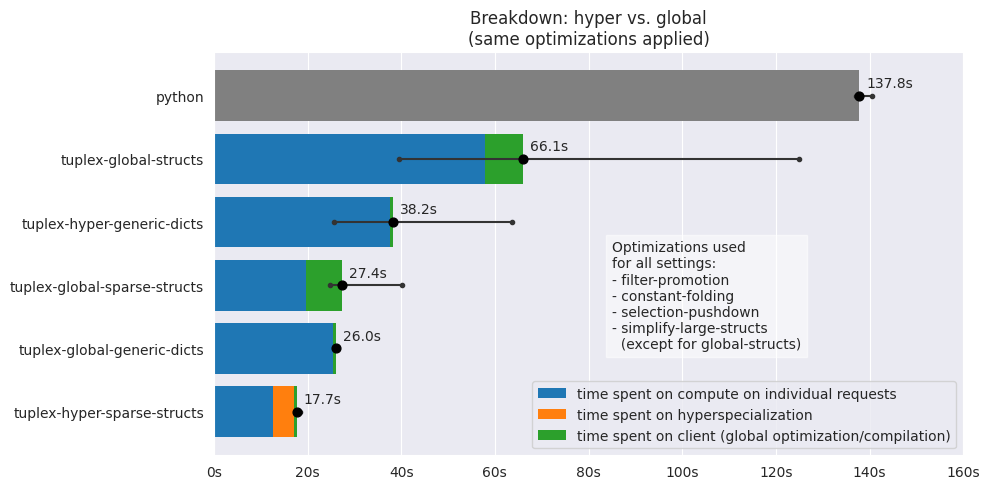

In [309]:
plot_breakdown(df, 'plots/tuplex-hyper-vs-global-breakdown.png')

In [310]:
!rm -rf plots

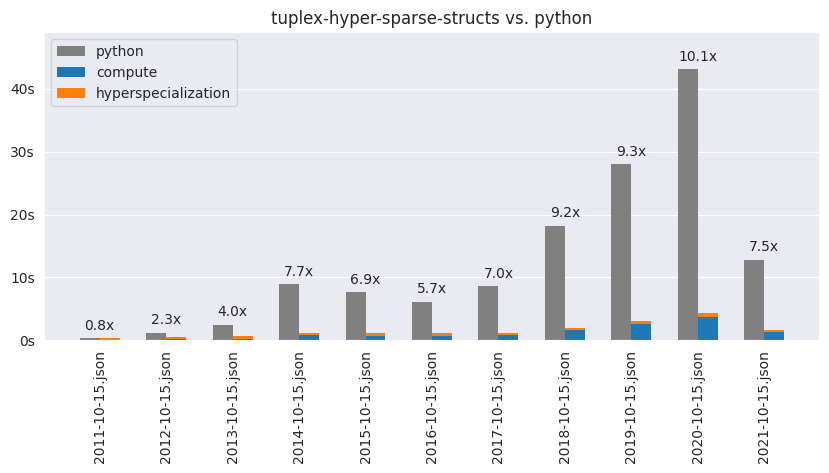

In [365]:
python_color = [.5]*3
hyper_color = sns.color_palette()[1]
compute_color = sns.color_palette()[0]

def plot_per_file_vs_python(df, mode_to_compare, path):
    b_width=.3
    # Plot breakdown per file path
   
    gdf = df.groupby(['mode', 'input_path'])[['time_in_s', 'hyperspecialization_time']].mean().reset_index()
    gdf['name'] = gdf['input_path'].apply(os.path.basename)
    gdf = gdf.fillna(0.0)
    
    gdf['compute_in_s'] = gdf['time_in_s'] - gdf['hyperspecialization_time']
    
    gdf
    
    py_df = gdf[gdf['mode'] == 'python'].sort_values(by='name').reset_index(drop=True)
    m_df = gdf[gdf['mode'] == mode_to_compare].sort_values(by='name').reset_index(drop=True)
    
    xq = np.array(range(len(py_df)))
    plt.figure(figsize=(10, 4))
    plt.bar(xq-b_width/2, py_df['compute_in_s'], b_width, color=python_color, edgecolor=None, lw=0, label='python')
    plt.bar(xq+b_width/2, m_df['compute_in_s'], b_width, color=compute_color, edgecolor=None, lw=0, label='compute')
    plt.bar(xq+b_width/2, m_df['hyperspecialization_time'], b_width, bottom=m_df['compute_in_s'], color=hyper_color, edgecolor=None, lw=0, label='hyperspecialization')
    
    sf = py_df['time_in_s'] / m_df['time_in_s']
    
    # print speedup on top of python
    for xi, yi, sfi in zip(xq, py_df['time_in_s'], sf):
        plt.text(xi, yi + 2., f'{sfi:.1f}x', horizontalalignment='center', verticalalignment='center')
    
    plt.xticks(rotation=90)
    ax = plt.gca()
    ax.set_xticks(xq, py_df['name'])
    ax.yaxis.set_major_formatter(EngFormatter(unit='s', sep=''))
    plt.legend(loc='best')
    plt.title(f'{mode_to_compare} vs. python')
    plt.ylim(0, 49)
    plt.grid(axis='x')

    os.makedirs(pathlib.Path(path).parent, exist_ok=True)
    plt.savefig(path, dpi=120, bbox_inches='tight', pad_inches=0.5, transparent=True)
plot_per_file_vs_python(df, 'tuplex-hyper-sparse-structs', 'tuplex-hyper-sparse-structs')

In [371]:
df_org = df.copy()

In [422]:
# overview plot of different aspects of a tuplex run.

df = df_org.copy()

# plot input row distribution together with runtime

normal_color = sns.color_palette()[0]
general_color = sns.color_palette()[1]
fallback_color = sns.color_palette()[2]

mode_to_select = 'tuplex-global-structs'
run_to_select = 1

def plot_row_count_breakdown(df, mode_to_select, run_to_select, path):
    df = df[df['mode'] == mode_to_select]
    
    df = df[df['run'] == run_to_select]
    
    df['name'] = df['input_path'].apply(os.path.basename)
    df = df.sort_values(by='name').reset_index(drop=True)
    
    for k in ['fallback', 'normal', 'general']:
        df[f'in_{k}'] = df['per_file_stats'].apply(lambda x: x['input'][k])
      
    xq = np.array(range(len(df['name'].unique())))
    plt.figure(figsize=(10, 4))
    
    n_normal= df['in_normal'].sum()
    n_general = df['in_general'].sum()
    n_fallback = df['in_fallback'].sum()
    
    total_time_in_s = df['total_time_in_s'].iloc[0]
    
    kwargs={'edgecolor':None, 'lw':0}
    h = df['in_normal']
    plt.bar(xq, h, label=f'normal ({n_normal:,} rows)', color=normal_color, **kwargs)
    hh = df['in_general']
    plt.bar(xq, hh, label=f'general ({n_general:,} rows)', color=general_color, bottom=h, **kwargs)
    hhh = df['in_fallback']
    plt.bar(xq, hhh, label=f'fallback ({n_fallback:,} rows)', color=fallback_color, bottom=h+hh, **kwargs)
    # sf = py_df['time_in_s'] / m_df['time_in_s']
    
    # print speedup on top of python
    yq = df['in_normal'] + df['in_general'] + df['in_fallback']
    for xi, yi, ti in zip(xq, yq, df['time_in_s']):
        plt.text(xi, yi + 1e5, f'{ti:.1f}s', horizontalalignment='center', verticalalignment='center')
    
    plt.xticks(rotation=90)
    ax = plt.gca()
    ax.set_xticks(xq, py_df['name'])
    ax.yaxis.set_major_formatter(EngFormatter(unit='', sep=''))
    plt.legend(loc='best')
    plt.title(f'{mode_to_compare}\ninput row breakdown\nrun={run}, total time={total_time_in_s:.1f}s')
    plt.ylabel('#input rows')
    plt.grid(axis='x')
    plt.ylim(0, 3.2*10e5)

    os.makedirs(pathlib.Path(path).parent, exist_ok=True)
    plt.savefig(path, dpi=120, bbox_inches='tight', pad_inches=0.5, transparent=True)

# df.head(1)

#df['metrics'].dropna().iloc[0]

In [430]:
combos = df[df['mode'] != 'python'][['mode', 'run']].values
for combo in combos:
    mode, run = combo

In [379]:
df.iloc[-1]['per_file_stats']

{'hyper_active': False,
 'input': {'fallback': 21313,
  'general': 0,
  'input_file_count': 1,
  'normal': 1056826,
  'total_input_row_count': 1078139,
  'unresolved': 0},
 'output': {'except': 0, 'normal': 21313},
 'request_total_time': 2.103734198,
 'spills': {'count': 0, 'size': 0},
 'timings': {'compile_time': 0.0160237,
  'fast_path_execution_time': 1.16461,
  'general_and_interpreter_time': 0.8840669999999999},
 'input_path': '/hot/data/github_daily/2021-10-15.json',
 'req_uri': '/hot/data/github_daily/2021-10-15.json:0-3573656628',
 'duration': 2.103734198,
 'num_input_rows': 1078139,
 'num_output_rows': 21313}

In [313]:
df

,run,mode,input_path,output_path,time_in_s,loading_time_in_s,total_time_in_s,input_row_count,output_row_count,benchmark,metrics,startup_time_in_s,per_file_stats,hyper,request_time_in_s,compile_time_in_s,fast_path_execution_time_in_s,general_and_interpreter_time_in_s,hyperspecialization_time
0,3,python,/hot/data/github_daily/2011-10-15.json,./local-exp/github//output/python,0.332677,NaN,135.317727,48899,1418,github,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
1,3,python,/hot/data/github_daily/2012-10-15.json,./local-exp/github//output/python,1.165685,NaN,135.317727,165692,5907,github,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
2,3,python,/hot/data/github_daily/2013-10-15.json,./local-exp/github//output/python,2.382360,NaN,135.317727,296456,10628,github,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
3,3,python,/hot/data/github_daily/2014-10-15.json,./local-exp/github//output/python,8.686575,NaN,135.317727,476393,16014,github,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
4,3,python,/hot/data/github_daily/2015-10-15.json,./local-exp/github//output/python,7.443211,NaN,135.317727,737714,25301,github,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,1,tuplex-hyper-generic-dicts,/hot/data/github_daily/2017-10-15.json,./local-exp/github//output/tuplex-hyper-generi...,1.917435,NaN,25.489599,910100,26107,github,"{'generate_llvm_time_s': 0.18195899999999998, ...",0.041606,"{'hyper_active': False, 'input': {'fallback': ...",0.0,1.917435,0.016077,0.859028,1.008630,NaN
381,1,tuplex-hyper-generic-dicts,/hot/data/github_daily/2018-10-15.json,./local-exp/github//output/tuplex-hyper-generi...,3.667080,NaN,25.489599,1522655,44404,github,"{'generate_llvm_time_s': 0.18195899999999998, ...",0.041606,"{'hyper_active': False, 'input': {'fallback': ...",0.0,3.667080,0.015812,1.743930,1.879720,NaN
382,1,tuplex-hyper-generic-dicts,/hot/data/github_daily/2019-10-15.json,./local-exp/github//output/tuplex-hyper-generi...,5.301087,NaN,25.489599,2134789,61337,github,"{'generate_llvm_time_s': 0.18195899999999998, ...",0.041606,"{'hyper_active': False, 'input': {'fallback': ...",0.0,5.301087,0.016088,2.672850,2.577940,NaN
383,1,tuplex-hyper-generic-dicts,/hot/data/github_daily/2020-10-15.json,./local-exp/github//output/tuplex-hyper-generi...,6.505908,NaN,25.489599,2963694,62354,github,"{'generate_llvm_time_s': 0.18195899999999998, ...",0.041606,"{'hyper_active': False, 'input': {'fallback': ...",0.0,6.505908,0.016041,3.849910,2.600200,NaN


In [174]:
modes

[0, 1, 2, 3, 4, 5]

In [61]:
df['hyperspecialization_time'].dropna().max()

0.73634

In [57]:
df.groupby('mode')['total_time_in_s'].mean()

mode
python                          137.681719
tuplex-global-generic-dicts      36.348259
tuplex-global-sparse-structs     27.047209
tuplex-global-structs            91.542349
tuplex-hyper-generic-dicts       36.175344
tuplex-hyper-sparse-structs      17.937899
Name: total_time_in_s, dtype: float64

In [41]:
!ls ../github/local-exp/github/results/tuplex-hyper-sparse-structs/

log-run-0.ndjson  log-run-1.txt     log-run-3.ndjson  log-run-4.txt
log-run-0.txt	  log-run-2.ndjson  log-run-3.txt     log-run-5.ndjson
log-run-1.ndjson  log-run-2.txt     log-run-4.ndjson  log-run-5.txt


In [34]:
#df[df['run'] != 0].groupby('input_path')['total_time_in_s'].mean()

In [2]:
#experimental_zip_path = '../results-Jul-16th.zip'

In [3]:
def load_cc_baselines(zf):
    df_cc = pd.DataFrame()
    # the C++ baseline are directly stored as csv
    for path in filter(lambda name: name.endswith('.csv'), zf.namelist()):
    
        if path.startswith('tuplex'):
            continue
        print(f'loading {path}')
        df_cc = pd.concat((df_cc, pd.read_csv(zf.open(path))))
    df_cc = df_cc[df_cc['mode'] != 'mode']
    for name in ['time_in_s', 'loading_time_in_s', 'total_time_in_s']:
        df_cc[name] = df_cc[name].astype(float)
    for name in ['input_row_count', 'output_row_count']:
        df_cc[name] = df_cc[name].astype(int)
    return df_cc

def load_tuplex_cc(zf, path='tuplex_best_results.csv', mode=None):
    df = pd.read_csv(zf.open(path))
    
    df = df.reset_index()[['index', 'mode', 'output_path', 'total_time_in_s', 'input_row_count', 'output_row_count']].rename(columns={'index':'mode', 'mode':'input_path', 'output_path':'time_in_s'})
    df['input_path'] = df['input_path'].apply(lambda x: x[:x.rfind(':')])
    df = df[df['mode'] != 'mode']
    df['loading_time_in_s'] = 0
    for name in ['time_in_s', 'loading_time_in_s', 'total_time_in_s']:
        df[name] = df[name].astype(float)
    for name in ['input_row_count', 'output_row_count']:
        df[name] = df[name].astype(int)
    if mode is not None:
        df['mode']=mode
    return df

def preprocess_python_df(df_tplx):
    df = df_tplx.copy()
    #df = df.dropna()
    df.drop(columns='input_path', inplace=True)
    columns_to_keep = ['run', 'benchmark', 'input_path',
                           'total_time_in_s', 'mode', 'output_path', 'startup_time_in_s']
    df = df.explode('per_file_stats')
    df.reset_index(drop=True, inplace=True)
    
    def expand_helper(t):
        if pd.isna(t) or t is None:
            return pd.Series()
        data = {'input_row_count': t['num_input_rows'],
                'output_row_count': t['num_output_rows'],
                'time_in_s': t['duration'],
                'input_path': t['input_path']
               }
        
        return pd.Series(list(data.values()), index=(data.keys()))
    df = pd.merge(df, df['per_file_stats'].apply(expand_helper), left_index=True, right_index=True)
    
    df['mode'] = 'python'
    df['loading_time_in_s'] = np.nan
    df['total_time_in_s'] = df['job_time_in_s']
    cols = ['mode', 'input_path', 'output_path', 'time_in_s', 'loading_time_in_s',
       'total_time_in_s', 'input_row_count', 'output_row_count']
    return df[cols]

def load_python(zf):
    df = pd.read_json(zf.open('python_baseline.ndjson'), lines=True)
    return preprocess_python_df(df)

with zipfile.ZipFile(experimental_zip_path, 'r') as zf:
    print(zf.namelist())
    
    df_cc = load_cc_baselines(zf)
    
    df_tuplex_cc = pd.DataFrame()
    for path in ['tuplex_best_results.csv', 'tuplex_cjson_results.csv', 'tuplex_yyjson_results.csv']:  
        df_tuplex_cc = pd.concat((load_tuplex_cc(zf, path), df_tuplex_cc))
    
    df_python = load_python(zf)
    
    

['best_results.csv', 'cjson_results.csv', 'cstruct_results.csv', 'python_baseline.ndjson', 'tuplex_best_results.csv', 'tuplex_cjson_results.csv', 'tuplex_yyjson_results.csv', 'yyjson_results.csv']
loading best_results.csv
loading cjson_results.csv
loading cstruct_results.csv
loading yyjson_results.csv


In [4]:
df_cc['mode'].unique(), df_tuplex_cc['mode'].unique(), df_python['mode'].unique()

(array(['best', 'cjson', 'cstruct', 'yyjson'], dtype=object),
 array(['tuplex-c++-yyjson', 'tuplex-c++-cjson', 'tuplex-c++-sparse'],
       dtype=object),
 array(['python'], dtype=object))

In [5]:
df = pd.concat((df_cc, df_python, df_tuplex_cc))

In [6]:
def plot_total_time(df, normalize_to_best=False):
    df = df.copy()
    from matplotlib.ticker import FuncFormatter
    plt.figure(figsize=(10,5))
    
    if normalize_to_best:
        best_mean = df[df['mode'] == 'best']['total_time_in_s'].mean()
        df['total_time_in_s'] = df['total_time_in_s'] / best_mean
    
    sns.barplot(data=df.sort_values(by='total_time_in_s'), x='mode', y='total_time_in_s', capsize=.2)
    plt.xticks(rotation=90)
    
    if not normalize_to_best:
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x)}s'))
        plt.ylabel('total time')
    else:
        plt.axhline(1, lw=2, linestyle='--', color='k')
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x)}x'))
        plt.ylabel('total time relative to best C++ baseline')

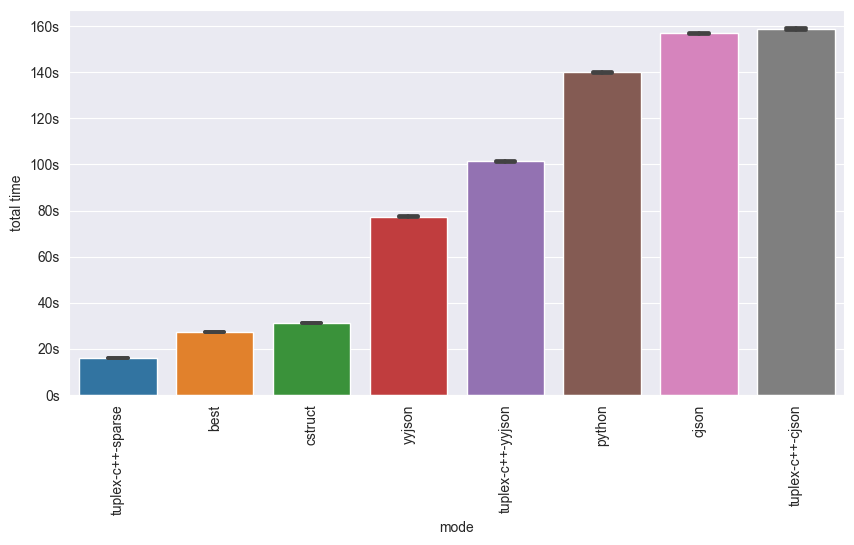

In [7]:
plot_total_time(df)

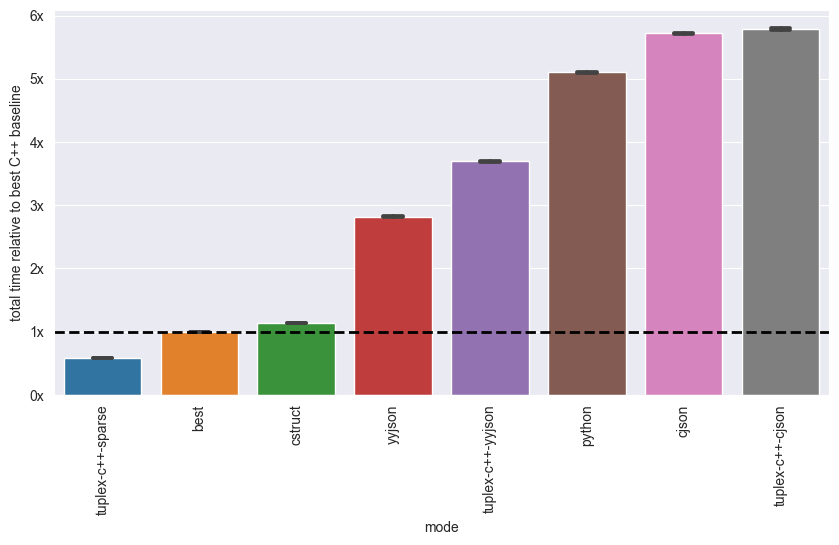

In [8]:
plot_total_time(df, True)

In [9]:
df[df['mode'] == 'tuplex-c++-sparse']['total_time_in_s'].mean()

16.151292333333338

In [10]:
df[df['mode'] == 'python']['total_time_in_s'].mean()

139.93298208713531

In [11]:
def plot_per_file_runtimes(df, modes=['best', 'python'], normalize_to=None):
    df = df.copy()
    from matplotlib.ticker import FuncFormatter
    plt.figure(figsize=(10,5))
    
    df = df[df['mode'].isin(modes)]
    import os
    df['input_path'] = df['input_path'].apply(os.path.basename)
    
    normalized_best_label = f'time_factor_compared_to_{normalize_to}'
    
    if normalize_to is not None:
        def helper(g):
            g[normalized_best_label] = g['time_in_s'] / g[g['mode'] == normalize_to]['time_in_s'].mean()
            return g
        df = df.groupby(['input_path'], group_keys=False).apply(helper)
    
    sns.barplot(df.sort_values(by=['time_in_s']), x='input_path',
                y=normalized_best_label if normalize_to is not None else 'time_in_s',
                hue='mode', errorbar=None, capsize=0)
    plt.xticks(rotation=90)
    
    if normalize_to is None:
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x)}s'))
        plt.ylabel('time per file')
    else:
        plt.axhline(1, lw=2, linestyle='--', color='k')
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x)}x'))
        plt.ylabel('total time relative to best C++ baseline')

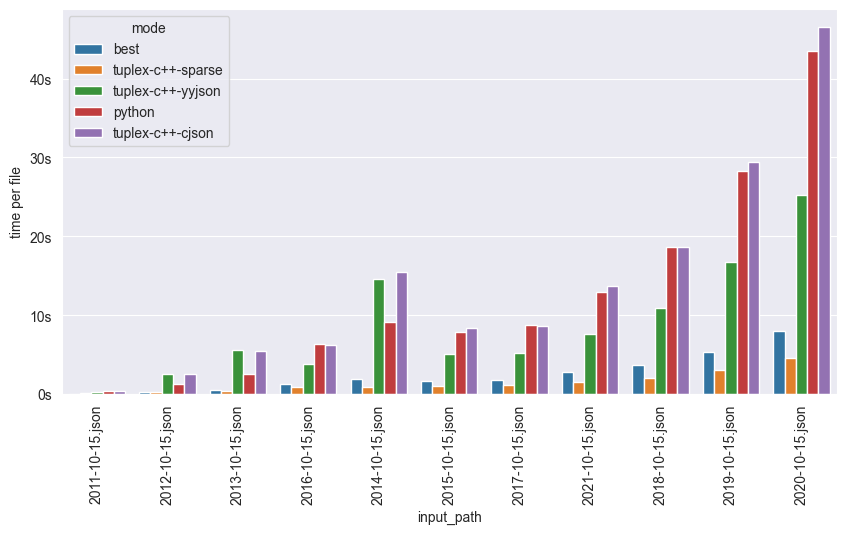

In [12]:
select_modes = ['best', 'tuplex-c++-sparse', 'tuplex-c++-yyjson', 'tuplex-c++-cjson', 'python']
plot_per_file_runtimes(df, modes=select_modes)

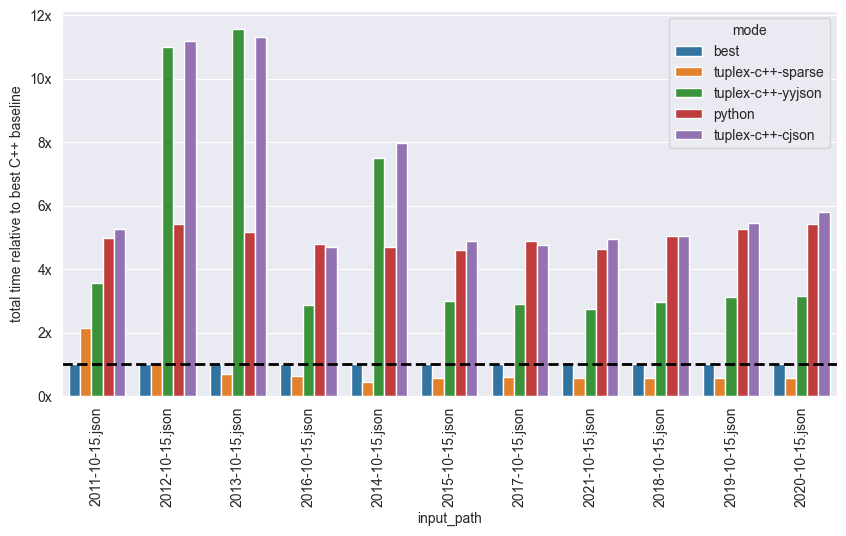

In [13]:
plot_per_file_runtimes(df, modes=select_modes, normalize_to='best')